# Análise do Histórico de Code Samples e o Impacto a Comunidade 

In [114]:
import os
os.chdir('C:\\Users\\Gabriel\\Documents\\gabrielsmenezes\\pesquisamestrado')

## Carregando as métricas evolutivas

In [115]:
import pandas as pd

In [116]:
# samples_android = pd.read_csv("listofsamples\\googlesamples.txt", sep="\n", header=None, names=["path"])
# samples_aws = pd.read_csv("listofsamples\\awssamples.txt", sep="\n", header=None, names=["path"])
# samples_azure = pd.read_csv("listofsamples\\azuresamples.txt", sep="\n", header=None, names=["path"])
# samples_spring = pd.read_csv("listofsamples\\springsamples.txt", sep="\n", header=None, names=["path"])

# samples_android["path"] = samples_android["path"].str.replace("/", "\\\\")
# samples_aws["path"] = samples_aws["path"].str.replace("/", "\\\\")
# samples_azure["path"] = samples_azure["path"].str.replace("/", "\\\\")
# samples_spring["path"] = samples_spring["path"].str.replace("/", "\\\\")

In [117]:
# samples = pd.concat([samples_android, samples_aws, samples_azure, samples_spring], axis=0)

In [118]:
list_samples = pd.read_csv("SBCARS2020\\samples.txt", sep="\n", header=None, names=["path"])
list_samples["windows_path"] = list_samples["path"].str.replace("/", "\\\\")

In [119]:
samples = [pd.read_csv("metricsbycommits\\"+sample+"__output.csv", usecols=[3,4,5,6,7], parse_dates=True) for sample in list_samples["windows_path"]]

In [120]:
df_metrics = pd.concat(samples, axis=0, ignore_index=True)

In [121]:
df_metrics['date'] = pd.to_datetime(df_metrics['date'].astype(str).str[:-6])

In [122]:
df_metrics.sort_values(by="date", inplace=True)

In [123]:
df_metrics.set_index(df_metrics["date"], inplace=True)

In [124]:
del df_metrics["date"]

In [125]:
df_metrics = df_metrics.groupby([(df_metrics.index.year), (df_metrics.index.month)]).sum()

## Carregando as métricas das perguntas do Stack Overflow

In [126]:
df = [pd.read_csv("stackoverflow\\"+sample+"_questions_and_answers_output.csv", usecols=[1,7], parse_dates=True) for sample in ["android", "aws", "azure", "spring"] ]
df_stackoverflow = pd.concat(df, axis=0, ignore_index=True)

In [127]:
# Get names of indexes for which column Age has value 30
indexNames = df_stackoverflow[~df_stackoverflow['path'].isin(list_samples["path"])].index
# Delete these row indexes from dataFrame
df_stackoverflow.drop(indexNames , inplace=True)

In [128]:
df_stackoverflow['question_creation_date'] = pd.to_datetime(df_stackoverflow['question_creation_date'])
df_stackoverflow.sort_values(by="question_creation_date", inplace=True)
df_stackoverflow.set_index(df_stackoverflow['question_creation_date'], inplace=True)
df_stackoverflow["count_questions"] = 1
df_stackoverflow=df_stackoverflow.groupby([(df_stackoverflow.index.year), (df_stackoverflow.index.month)]).sum()

## Mergeando os dois conjuntos

In [129]:
df = pd.concat([df_metrics,df_stackoverflow], axis=1)
df["count_questions"].fillna(0, inplace=True)
df.fillna(method="ffill", inplace=True)

## Normalização dos dados

In [130]:
normalized_df=(df-df.min())/(df.max()-df.min())

## Visão geral das métricas

In [131]:
normalized_df.describe()

,numberOfJavaFiles,countLineCode/numberOfJavaFiles,SumCyclomaticStrict/CountDeclMethod,readability,count_questions
count,87.000000,87.000000,87.000000,87.000000,87.000000
mean,0.255693,0.325852,0.224069,0.089177,0.417625
std,0.228968,0.231788,0.169695,0.124617,0.304057
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.060067,0.143083,0.110198,0.032883,0.133333
50%,0.206234,0.283479,0.185758,0.054386,0.400000
75%,0.382374,0.461784,0.299109,0.113087,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Gráfico do número de arquivos Java

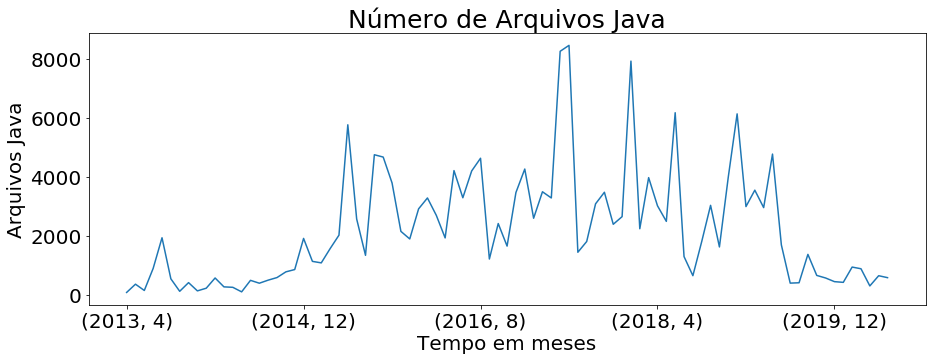

In [132]:
subplot = df["numberOfJavaFiles"].plot(figsize=(15,5), fontsize=20)
subplot.set_title("Número de Arquivos Java", fontsize=25)
subplot.set_ylabel("Arquivos Java", fontsize=20)
subplot.set_xlabel("Tempo em meses", fontsize=20)
subplot.figure.savefig("SBCARS2020/arquivosJava.pdf",bbox_inches = 'tight')

### Gráfico do número linhas de código por arquivo Java

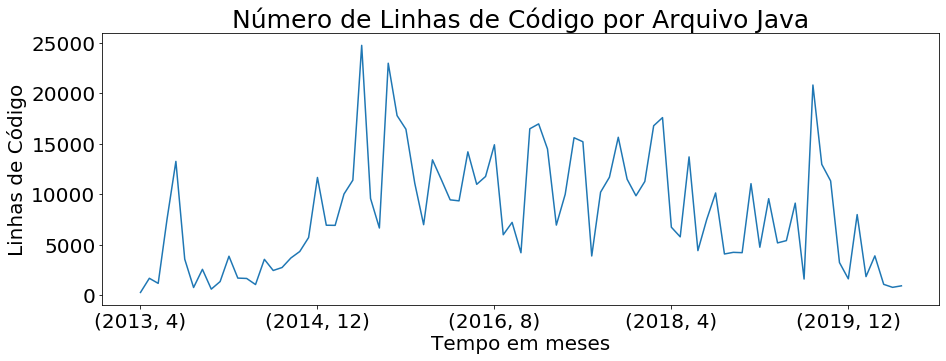

In [133]:
subplot = df["countLineCode/numberOfJavaFiles"].plot(figsize=(15,5), fontsize=20)
subplot.set_title("Número de Linhas de Código por Arquivo Java", fontsize=25)
subplot.set_ylabel("Linhas de Código", fontsize=20)
subplot.set_xlabel("Tempo em meses", fontsize=20)
subplot.figure.savefig("SBCARS2020/loc.pdf",bbox_inches = 'tight')

### Gráfico da complexidade por método

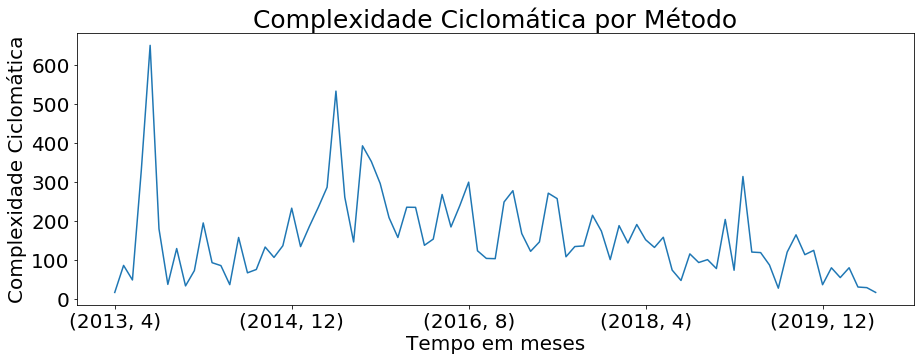

In [134]:
subplot = df["SumCyclomaticStrict/CountDeclMethod"].plot(figsize=(15,5), fontsize=20)
subplot.set_title("Complexidade Ciclomática por Método", fontsize=25)
subplot.set_ylabel("Complexidade Ciclomática", fontsize=20)
subplot.set_xlabel("Tempo em meses", fontsize=20)
subplot.figure.savefig("SBCARS2020/cc.pdf",bbox_inches = 'tight')

### Gráfico da readability por arquivo Java

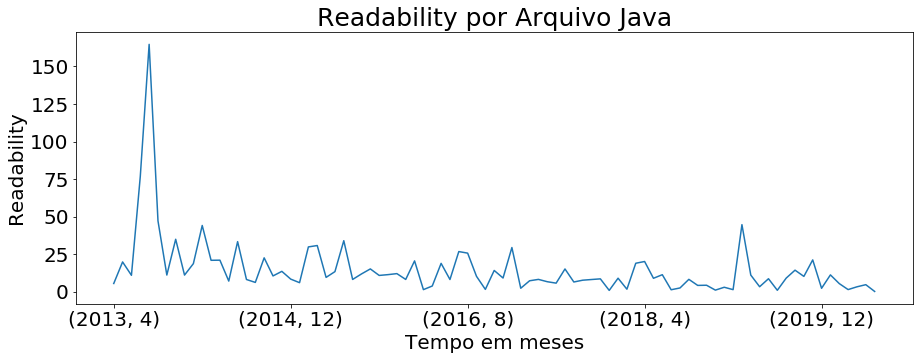

In [135]:
subplot = df["readability"].plot(figsize=(15,5), fontsize=20)
subplot.set_title("Readability por Arquivo Java", fontsize=25)
subplot.set_ylabel("Readability", fontsize=20)
subplot.set_xlabel("Tempo em meses", fontsize=20)
subplot.figure.savefig("SBCARS2020/readability.pdf",bbox_inches = 'tight')

## Teste de Mann Kendall

Hipótese nula: Não há tendência monotonica.

Hipótese alternativa: Existe uma tendência.

Se o p-value < 0.05 então a hipotese nula é rejeitada

In [136]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [137]:
import pymannkendall as mk

### Teste de tendência (MannKendallTest) para número de arquivos Java

In [138]:
mk.original_test(normalized_df["numberOfJavaFiles"])

Mann_Kendall_Test(trend='increasing', h=True, p=0.009242665178066378, z=2.602945475151715, Tau=0.19005613472333602, s=711.0, var_s=74402.33333333333, slope=0.0021972772868402214, intercept=0.1117506567948411)

### Teste de tendência (MannKendallTest) para número linhas de código por arquivo Java

In [139]:
mk.original_test(normalized_df["countLineCode/numberOfJavaFiles"])

Mann_Kendall_Test(trend='no trend', h=False, p=0.24666883195759404, z=1.1584784721076404, Tau=0.08473670141673349, s=317.0, var_s=74404.33333333333, slope=0.0011041590107721728, intercept=0.23600016142117208)

### Teste de tendência (MannKendallTest) para complexidade por método

In [140]:
mk.original_test(normalized_df["SumCyclomaticStrict/CountDeclMethod"])

Mann_Kendall_Test(trend='decreasing', h=True, p=0.017519775678311866, z=-2.3756140820435157, Tau=-0.17348302592889603, s=-649.0, var_s=74404.33333333333, slope=-0.0014771242509658946, intercept=0.2492741345808932)

### Teste de tendência (MannKendallTest) para readability por arquivo Java

In [141]:
mk.original_test(normalized_df["readability"])

Mann_Kendall_Test(trend='decreasing', h=True, p=2.2537102515318708e-06, z=-4.729231737401443, Tau=-0.34509489441325847, s=-1291.0, var_s=74404.33333333333, slope=-0.0009840996283990765, intercept=0.09670276661212138)

### Teste de tendência (MannKendallTest) para número de perguntas no SO

In [142]:
mk.original_test(normalized_df["count_questions"])

Mann_Kendall_Test(trend='increasing', h=True, p=0.00015208047793358048, z=3.7876473780909556, Tau=0.2753274525527934, s=1030.0, var_s=73806.0, slope=0.005649717514124295, intercept=0.15706214689265535)

## Teste de Normalidade

Hipótese nula: A população tem distribuição normal

Hipótese alternativa: A população não tem distribuição normal

Se o p-value < 0.05 então a hipotese nula é rejeitada

In [143]:
from scipy import stats

### Teste de normalidade (Shapiro-Wilk) para número de arquivos Java

In [144]:
stats.shapiro(normalized_df["numberOfJavaFiles"])

(0.8812229633331299, 9.149527500085242e-07)

### Teste de normalidade (Shapiro-Wilk) para número linhas de código por arquivo Java

In [145]:
stats.shapiro(normalized_df["countLineCode/numberOfJavaFiles"])

(0.9476915597915649, 0.001508408458903432)

### Teste de normalidade (Shapiro-Wilk) para complexidade por método

In [146]:
stats.shapiro(normalized_df["SumCyclomaticStrict/CountDeclMethod"])

(0.8700959086418152, 3.3738865568011533e-07)

### Teste de normalidade (Shapiro-Wilk) para readability por arquivo Java

In [147]:
stats.shapiro(normalized_df["readability"])

(0.5365400314331055, 3.9715782474813305e-15)

### Teste de normalidade (Shapiro-Wilk) para número de perguntas no SO

In [148]:
stats.shapiro(normalized_df["count_questions"])

(0.9415321946144104, 0.000661201891489327)

## Teste de Correlação

Hipótese nula: os dois conjuntos de dados não são correlacionados

Hipótese alternativa: os dois conjuntos de dados são correlacionados

Se o p-value < 0.05 então a hipotese nula é rejeitada

In [149]:
from scipy import stats

### Teste de correlação (Spearman) questões do SO e para número de arquivos Java

In [150]:
stats.spearmanr(normalized_df["count_questions"], normalized_df["numberOfJavaFiles"])

SpearmanrResult(correlation=0.6316570064809761, pvalue=5.3789892376497884e-11)

### Teste de correlação (Spearman) para questões do SO e número linhas de código por arquivo Java

In [151]:
stats.spearmanr(normalized_df["count_questions"], normalized_df["countLineCode/numberOfJavaFiles"])

SpearmanrResult(correlation=0.5624960924232166, pvalue=1.427814836131648e-08)

### Teste de correlação (Spearman) para questões do SO e complexidade por método

In [152]:
stats.spearmanr(normalized_df["count_questions"], normalized_df["SumCyclomaticStrict/CountDeclMethod"])

SpearmanrResult(correlation=0.3019342359927964, pvalue=0.004480696478001201)

### Teste de correlação (Spearman) para questões do SO e readability por arquivo Java

In [153]:
stats.spearmanr(normalized_df["count_questions"], normalized_df["readability"])

SpearmanrResult(correlation=-0.288747018634497, pvalue=0.006681211090624801)

## Gráficos StackOverflow X Métricas

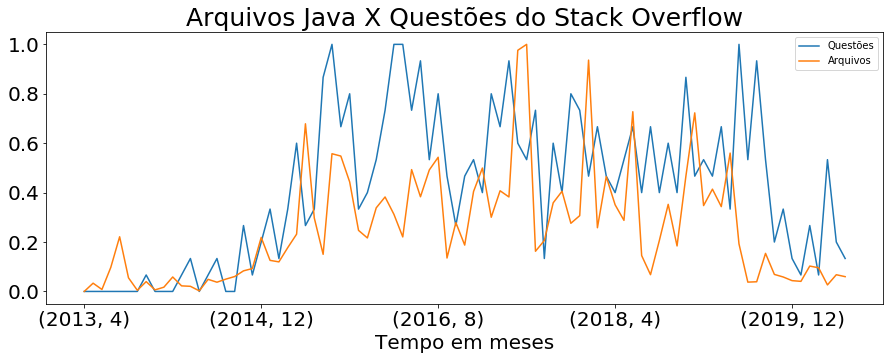

In [154]:
subplot = normalized_df["count_questions"].plot(figsize=(15,5), fontsize=20, legend=True, label="Questões")
subplot = normalized_df["numberOfJavaFiles"].plot(figsize=(15,5), fontsize=20, legend=True, label="Arquivos")
subplot.set_title("Arquivos Java X Questões do Stack Overflow", fontsize=25)
subplot.set_xlabel("Tempo em meses", fontsize=20)
subplot.figure.savefig("SBCARS2020/arquivosVsQuestões.pdf",bbox_inches = 'tight')

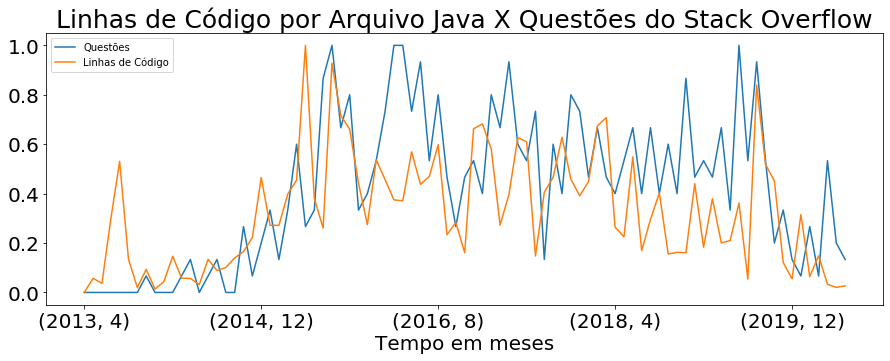

In [155]:
subplot = normalized_df["count_questions"].plot(figsize=(15,5), fontsize=20, legend=True, label="Questões")
subplot = normalized_df["countLineCode/numberOfJavaFiles"].plot(figsize=(15,5), fontsize=20, legend=True, label="Linhas de Código")
subplot.set_title("Linhas de Código por Arquivo Java X Questões do Stack Overflow", fontsize=25)
subplot.set_xlabel("Tempo em meses", fontsize=20)
subplot.figure.savefig("SBCARS2020/linhasVsQuestões.pdf",bbox_inches = 'tight')

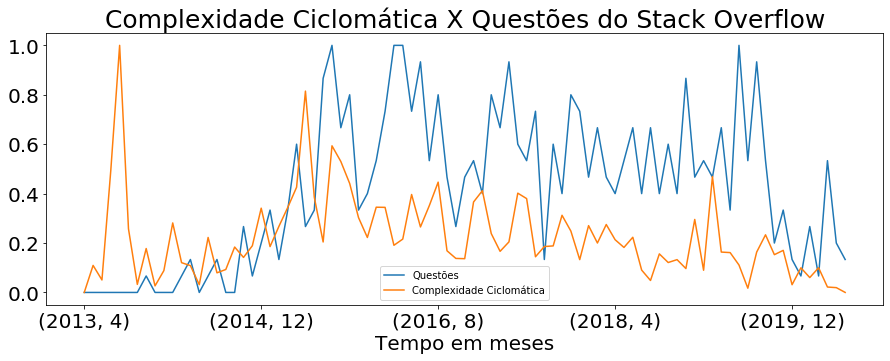

In [156]:
subplot = normalized_df["count_questions"].plot(figsize=(15,5), fontsize=20, legend=True, label="Questões")
subplot = normalized_df["SumCyclomaticStrict/CountDeclMethod"].plot(figsize=(15,5), fontsize=20, legend=True, label="Complexidade Ciclomática")
subplot.set_title("Complexidade Ciclomática X Questões do Stack Overflow", fontsize=25)
subplot.set_xlabel("Tempo em meses", fontsize=20)
subplot.figure.savefig("SBCARS2020/ccVsQuestões.pdf",bbox_inches = 'tight')

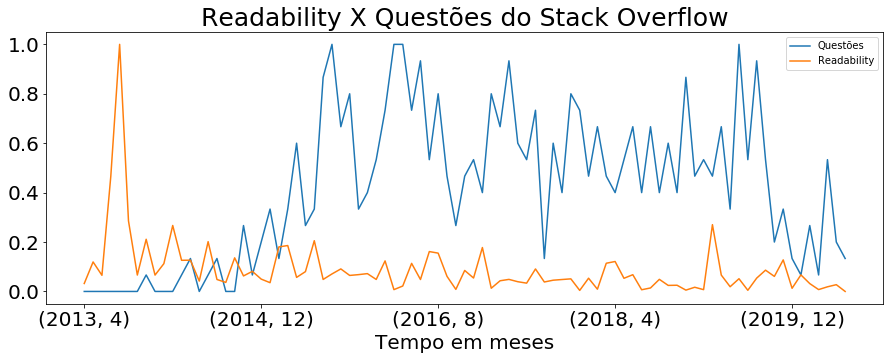

In [157]:
subplot = normalized_df["count_questions"].plot(figsize=(15,5), fontsize=20, legend=True, label="Questões")
subplot = normalized_df["readability"].plot(figsize=(15,5), fontsize=20, legend=True, label="Readability")
subplot.set_title("Readability X Questões do Stack Overflow", fontsize=25)
subplot.set_xlabel("Tempo em meses", fontsize=20)
subplot.figure.savefig("SBCARS2020/readabilityVsQuestões.pdf",bbox_inches = 'tight')

***Obs1: no teste de correlaçao o primeiro valor da tupla é o coeficiente da correlação e o segundo valor da tupla é o p-value***

***Obs2: Todos os dados foram normalizados***